<a href="https://colab.research.google.com/github/lakshrav/Deep_Learning_Project/blob/main/Music_Genre_Classification_on_Generated_Music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music and Deep Learning: Music Generation using LSTMs, Music Genre Classification using Transfer Learning and an Investigation of the Acoustic Similarity between Music and Speech

CS6005 Deep Learning <br>

Submitted by <br>

Rithvik Senthil (2020103039) <br>
Abirami G (2020103502, Batch : Q) <br>
Lakshana (2020103537, Batch : Q)


# A. Music Genre Classification

# 1. Installing Dependencies and Setup

In [1]:
!pip install livelossplot

In [2]:
import random, os, glob # default python modules that let me randomise and manipulate files
import numpy as np # for data manipulation through arrays
import tensorflow as tf
from keras.models import Sequential # the model we will use
from keras.layers import Dropout, Dense, Conv2D, MaxPool2D, Flatten, Reshape, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping # for better training
from tensorflow.keras.applications import VGG19 # transfer learning model
from keras import backend
from livelossplot import PlotLossesKeras # to visualy display how my model improves as training progresses
import librosa # to demonstrate the creation of a mel spectrogram
from librosa.display import specshow
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import pandas as pd
import random
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
from IPython.core.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")
from scipy.ndimage import zoom
import cv2
from sklearn.model_selection import train_test_split


In [3]:
# utility function to initialise a random seed
def setRandom():
    seed = 0 # random seed value
    os.environ["PYTHONHASHSEED"] = str(seed) # if this is not set, a random value is used to seed the hashes of some objects
    random.seed(seed) # sets the base python and numpy random seeds
    np.random.seed(seed)
    tf.random.set_seed(seed) # sets the tensorflow random seed
    tf.compat.v1.set_random_seed(seed)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 2. Sampling the Data

AUDIO FILE AND ITS MEL_SPECTROGRAM



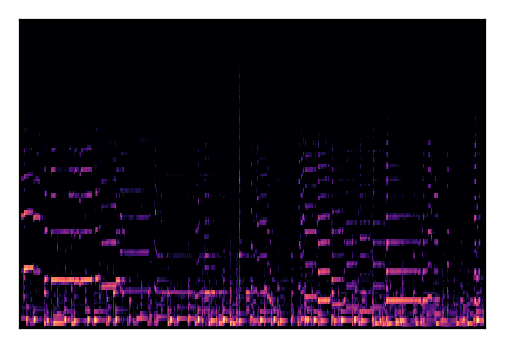

In [6]:
filePath = "/content/gdrive/MyDrive/CEG/Semester 7/DL_project/DL Project/Datasets/Genre/genres_original/jazz/jazz.00099.wav" # an example file

#librosa is a python package for music and audio analysis. It provides the building blocks necessary to create music information retrieval systems.
file, samplingRate = librosa.load(filePath)
example, _ = librosa.effects.trim(file)

hopLength = 512 # the number of samples between successive columns of the spectrogram

spectrogram = librosa.power_to_db(librosa.feature.melspectrogram(y = example, sr = samplingRate, n_fft = 2048, hop_length = hopLength, n_mels = 128, power = 4.0), ref = np.max)
print("AUDIO FILE AND ITS MEL_SPECTROGRAM\n")
plt.figure(figsize = (3, 2))
librosa.display.specshow(spectrogram, sr = samplingRate, hop_length = hopLength, x_axis = "off", y_axis = "off")
ipd.Audio(example, rate = samplingRate)

# 3. Preprocessing the Data

1. Removing Erroneous Values

In [8]:
source = "/content/gdrive/MyDrive/CEG/Semester 7/DL_project/DL Project/Datasets/Genre/images_original/" # source folder path
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"] # list with the genre folder names

for genre in genres: # iterate through each genre folder
    path = os.path.join(source, genre)
    pngs = [i for i in os.listdir(path) if i[-4:] == ".png"] # get a list of .png files in the genre folder
    print(f"Size of {genre} dataset: {len(pngs)} files.")

Size of blues dataset: 100 files.
Size of classical dataset: 100 files.
Size of country dataset: 100 files.
Size of disco dataset: 100 files.
Size of hiphop dataset: 100 files.
Size of jazz dataset: 99 files.
Size of metal dataset: 100 files.
Size of pop dataset: 100 files.
Size of reggae dataset: 100 files.
Size of rock dataset: 100 files.


2. Splitting the Dataset

In [9]:
split = [80, 9, 10]
train, val, test = {}, {}, {} # empty dictionaries to store the filepaths
trainLen, valLen, testLen = {}, {}, {} # empty dictionaries to store the number of files under each genre for each dataset
dictionaries = [train, val, test]


# train : blues : {.../1.png,.../2.png}, classical : {.../1.png,.../2.png} ...
# test : blues : {.../1.png,.../2.png}, classical : {.../1.png,.../2.png} ...
# val : blues : {.../1.png,.../2.png}, classical : {.../1.png,.../2.png} ...

for d in dictionaries:
    if d == train: num = slice(0, split[0])
    elif d == val: num = slice(split[0], split[0] + split[1])
    else: num = slice(split[0] + split[1], split[0] + split[1] + split[2])
    for genre in genres: # iterate through each genre folder
        path = os.path.join(source, genre)
        pngs = glob.glob(os.path.join(path, "*.png")) # get a list of .png filepaths in the genre folder
        selected = pngs[num] # take the first 80 files
        d[genre] = selected # store the selected files in the dictionary

lenDictionaries = [{genre: len(d[genre]) for genre in genres} for d in dictionaries]

print(f"\033[1mTraining:\033[0m {lenDictionaries[0]}")
print(f"\033[1mValidation:\033[0m {lenDictionaries[1]}")
print(f"\033[1mTest:\033[0m {lenDictionaries[2]}")

Training: {'blues': 80, 'classical': 80, 'country': 80, 'disco': 80, 'hiphop': 80, 'jazz': 80, 'metal': 80, 'pop': 80, 'reggae': 80, 'rock': 80}
Validation: {'blues': 9, 'classical': 9, 'country': 9, 'disco': 9, 'hiphop': 9, 'jazz': 9, 'metal': 9, 'pop': 9, 'reggae': 9, 'rock': 9}
Test: {'blues': 10, 'classical': 10, 'country': 10, 'disco': 10, 'hiphop': 10, 'jazz': 10, 'metal': 10, 'pop': 10, 'reggae': 10, 'rock': 10}


3. Data Formatting

In [10]:
batchSize = 32 # typical batch size for a neural network
genreMap = {
    "blues": 0,
    "classical": 1,
    "country": 2,
    "disco": 3,
    "hiphop": 4,
    "jazz": 5,
    "metal": 6,
    "pop": 7,
    "reggae": 8,
    "rock": 9
}
inverseGenreMap = {value: key for key, value in genreMap.items()}

def createDataset(d):
    imgSize = (288, 432) # define image and batch parameters
    imageList, labelList = [], [] # create lists to store images and labels

    for genre, paths in d.items():
        for path in paths:
            image = tf.cast(tf.image.resize(tf.image.decode_png(tf.io.read_file(path), channels = 3), imgSize), tf.float32) / 255.0 # normalise pixel values between 0 and 1 (preprocessing!)
            imageList.append(image)
            labelList.append(genreMap[genre]) # convert genre to its integer label

    dataset = tf.data.Dataset.from_tensor_slices((imageList, labelList)).shuffle(buffer_size=len(imageList)).batch(batchSize) # create and return tensorflow dataset
    return(dataset)

def prep(ds):
    out = (
        ds.map(lambda image, label: (tf.image.convert_image_dtype(image, tf.float32), label)) # modifies the image tensor's data type to floats
        .cache() # cache dataset elements in memory or on disk to speed up data loading
        .prefetch(buffer_size = tf.data.experimental.AUTOTUNE) # prefetch dataset elements in the background and automatically optimise data loading
    )
    return out # return the prepared and optimised dataset

training, validation, testing = prep(createDataset(train)), prep(createDataset(val)), prep(createDataset(test))
print("Datasets created.") # to let me know when it's finished running (:

Datasets created.


Training Examples:


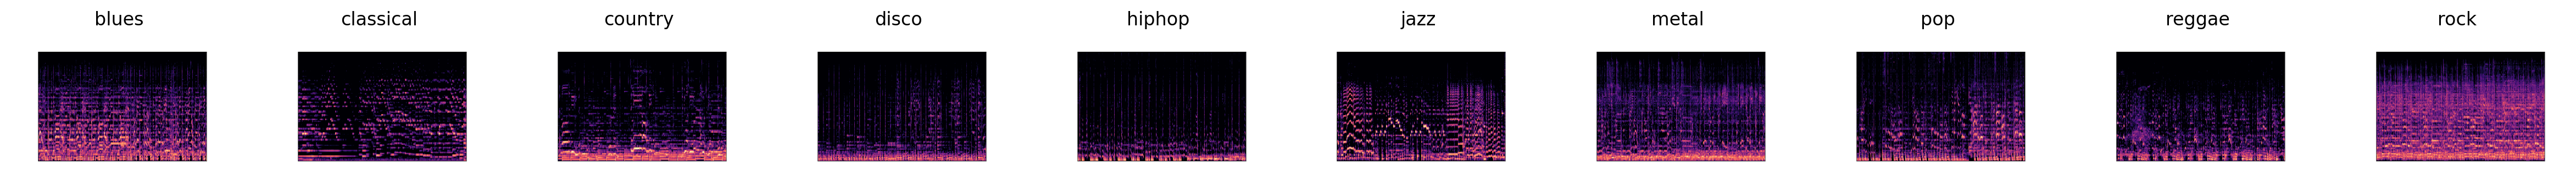

Validation Examples:


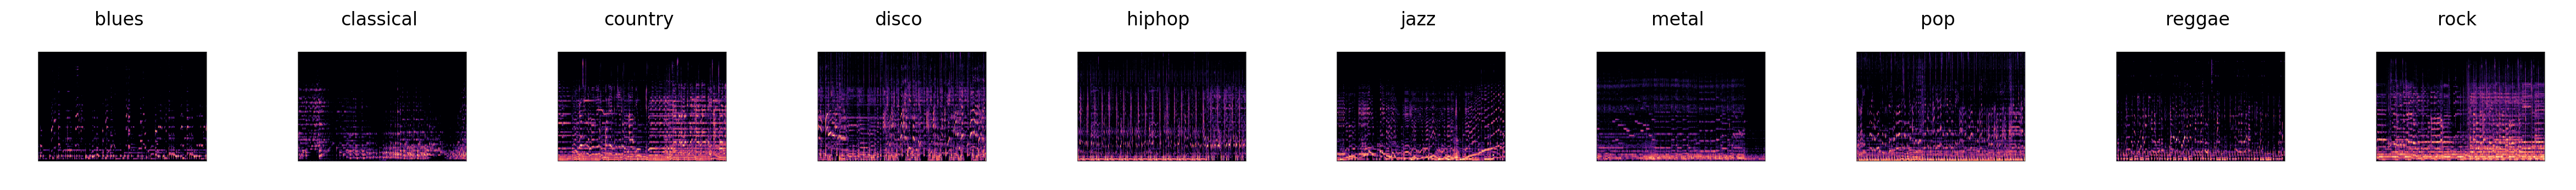

Testing Examples:


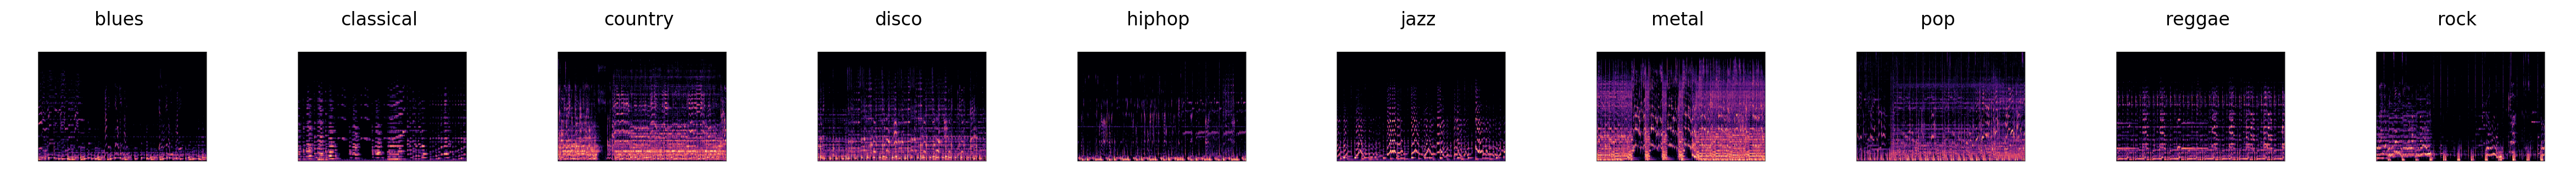

In [11]:
def view_dataset(dataset):
    genreExamples = {}  # dictionary to store examples for each label

    for images, labels in dataset:
        for image, label in zip(images, labels):
            label = int(label.numpy())  # convert label tensor to integer
            if label not in genreExamples:
                genreExamples[label] = image

        if len(genreExamples) == len(genres):
            break

    # display the randomly chosen examples
    plt.figure(figsize = (30, 20))
    for label, image in genreExamples.items():
        ax = plt.subplot(1, len(genres), label + 1)
        plt.imshow(image)
        plt.title(inverseGenreMap[label])
        plt.axis("off")
    plt.show()

print("\033[1mTraining Examples:\033[0m"); view_dataset(training) # shows a labelled example of a mel spectrogram from each genre from each dataset
print("\033[1mValidation Examples:\033[0m"); view_dataset(validation)
print("\033[1mTesting Examples:\033[0m"); view_dataset(testing)

# 4. Choosing and Training a Model

1. Transfer Learning Model using Inceptionv3 architecture

In [12]:
inputShape = [288, 432, 3] # the shape of the images (288px tall, 432px wide, and 3 colour channels/RGB)

earlyStopping = EarlyStopping( # a custom early stopping setup to automatically stop training when loss doesn't increase enough after a number of epochs
    min_delta = 0.001, # minimium amount of change to count as an improvement
    patience = 20, # how many epochs to wait before stopping
    restore_best_weights = True # tells it to restore back to when loss was at its lowest value
)

In [13]:
from tensorflow.keras.applications import InceptionV3 # transfer learning model


baseModel = InceptionV3(input_shape = inputShape, weights = "imagenet", include_top = False, pooling = "avg")

for layer in baseModel.layers:
    layer.trainable = False # freeze the pre-trained layers

transfer = Sequential([
    baseModel,

    Flatten(),
    BatchNormalization(),
    Dense(512, activation = "relu"),
    Dropout(0.3),
    Dense(256, activation = "relu"),
    Dropout(0.3), # dropout layer to prevent overfitting
    Dense(128, activation = "relu"),
    Dropout(0.3),
    Dense(len(genres), activation = "softmax")
])

transfer.compile(optimizer = tf.keras.optimizers.SGD(lr = 0.0001), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
transfer.summary()

87910968/87910968 [==============================] - 0s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                        

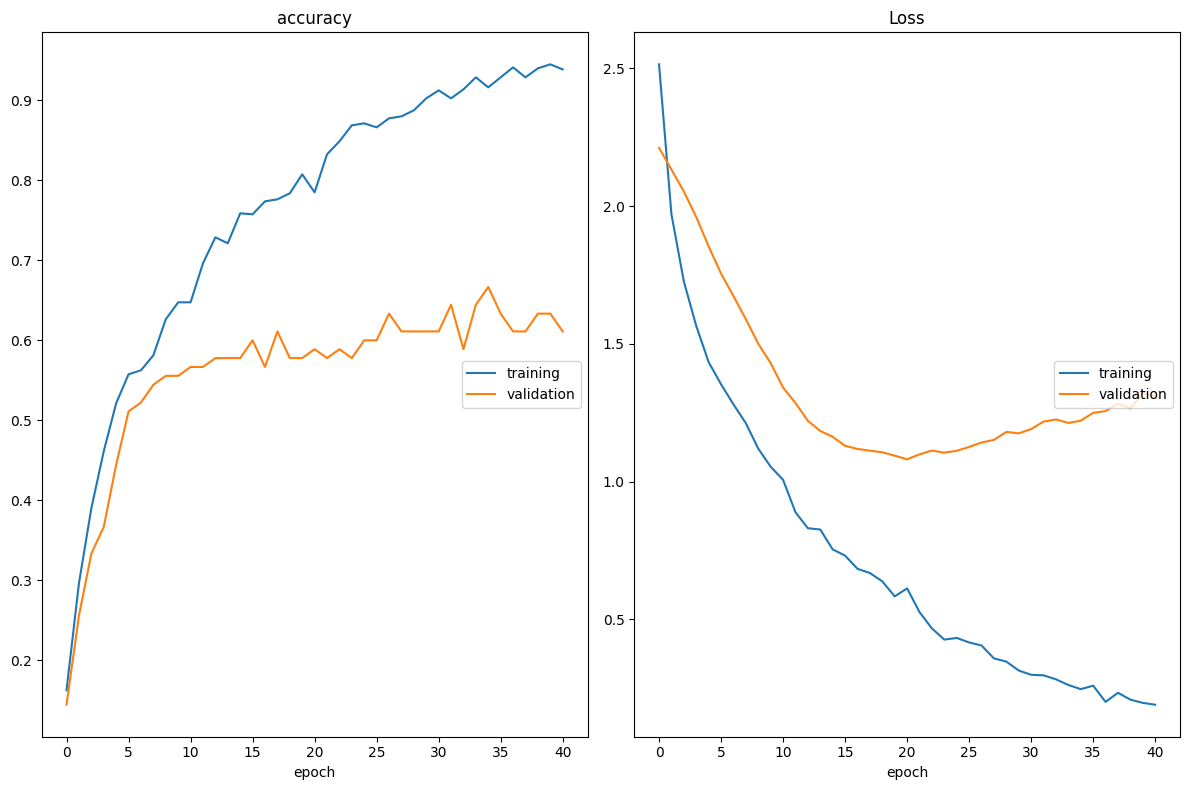

accuracy
	training         	 (min:    0.162, max:    0.945, cur:    0.939)
	validation       	 (min:    0.144, max:    0.667, cur:    0.611)
Loss
	training         	 (min:    0.190, max:    2.515, cur:    0.190)
	validation       	 (min:    1.081, max:    2.212, cur:    1.311)
25/25 [==============================] - 6s 224ms/step - loss: 0.1897 - accuracy: 0.9388 - val_loss: 1.3110 - val_accuracy: 0.6111


In [ ]:
setRandom()
transferHistory = transfer.fit(training, validation_data = validation, batch_size = batchSize, epochs = 500, verbose = 1, callbacks = [earlyStopping, PlotLossesKeras()])

2. Custom CNN architecture

In [ ]:
cnn = Sequential([
    BatchNormalization(input_shape = inputShape),

    Conv2D(32, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),

    Conv2D(64, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),

    Conv2D(128, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),

    Conv2D(256, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),

    Conv2D(512, (3, 3), activation = "relu"),
    MaxPool2D((2, 2)),

    Flatten(),
    Dense(1024, activation = "relu"),
    Dropout(0.5),
    Dense(512, activation = "relu"),
    Dropout(0.5),
    BatchNormalization(),
    Dense(len(genres), activation = "softmax")
])

cnn.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 0.001), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"]) # "sparse_categorical_crossentropy" because labels are integers
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_95 (Ba  (None, 288, 432, 3)       12        
 tchNormalization)                                               
                                                                 
 conv2d_94 (Conv2D)          (None, 286, 430, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 143, 215, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_95 (Conv2D)          (None, 141, 213, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 70, 106, 64)       0         
 g2D)                                                            
                                                      

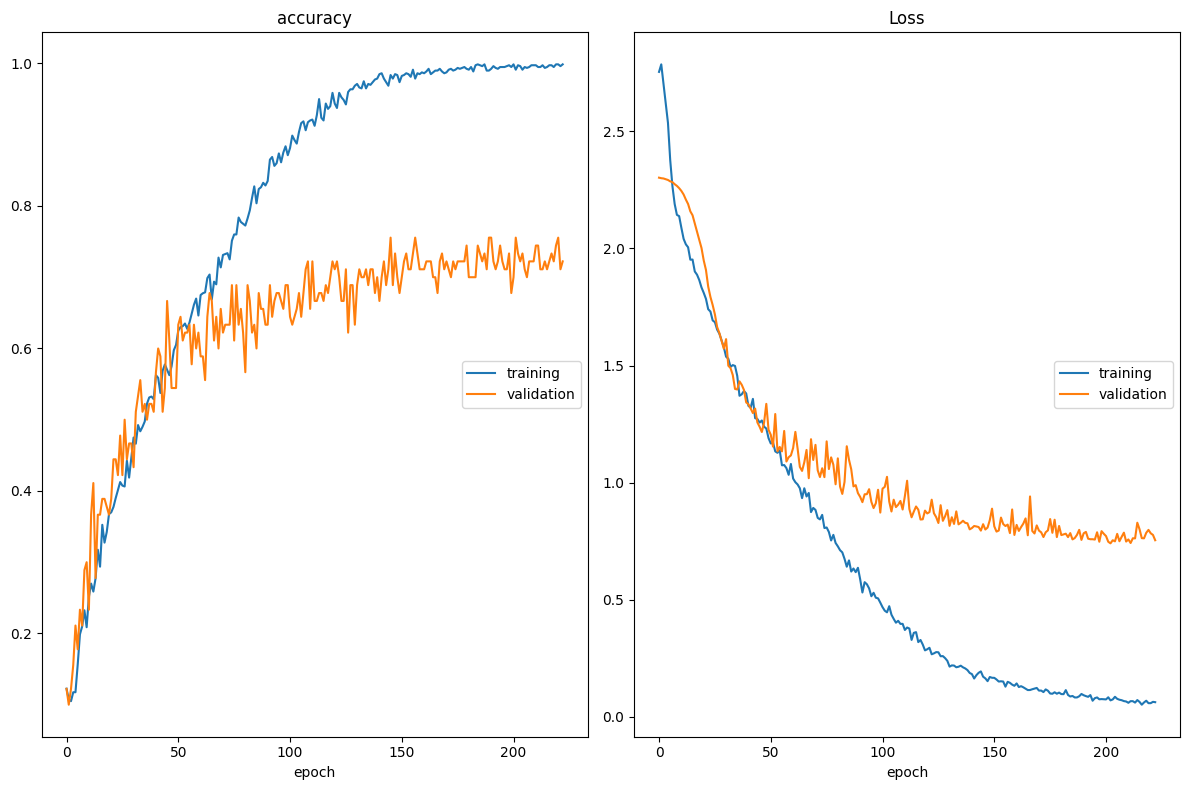

accuracy
	training         	 (min:    0.105, max:    0.999, cur:    0.999)
	validation       	 (min:    0.100, max:    0.756, cur:    0.722)
Loss
	training         	 (min:    0.051, max:    2.786, cur:    0.062)
	validation       	 (min:    0.740, max:    2.302, cur:    0.754)
25/25 [==============================] - 5s 198ms/step - loss: 0.0619 - accuracy: 0.9987 - val_loss: 0.7536 - val_accuracy: 0.7222


In [ ]:
setRandom()
cnn.fit(training, validation_data = validation, batch_size = batchSize, epochs = 500, verbose = 1, callbacks = [earlyStopping, PlotLossesKeras()])

In [ ]:
cnn.save('/content/drive/MyDrive/CEG/Semester 7/DL_project/DL Project/Models/cnn', save_format="h5")

In [15]:
# Load saved CNN model

cnn = tf.keras.models.load_model('/content/gdrive/MyDrive/CEG/Semester 7/DL_project/DL Project/Models/cnn')

# 5. Test Data Report and Confusion Matrix

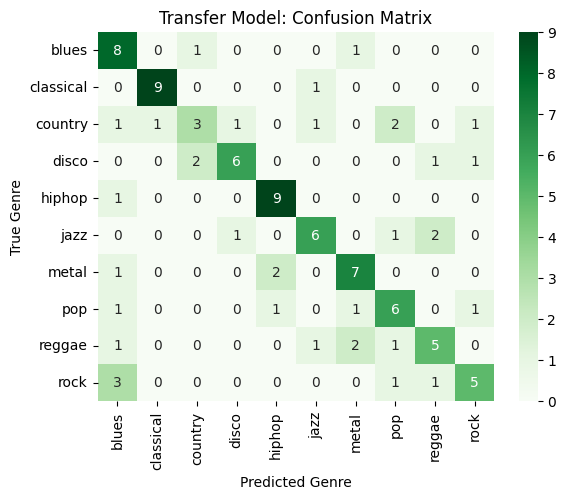

Transfer Model
Training Accuracy: 94.5% 
Train Loss: 0.3027

Validation Accuracy: 58.8889% 
Test Loss: 1.0805

Testing Accuracy: 64.0% 
Test Loss: 1.1446


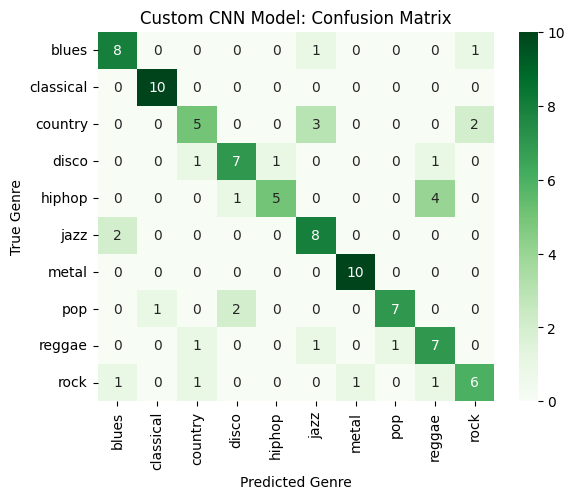

Custom CNN Model
Training Accuracy: 99.875% 
Train Loss: 0.0132

Validation Accuracy: 73.3333% 
Test Loss: 0.7405

Testing Accuracy: 73.0% 
Test Loss: 0.8548


In [ ]:
def confusionMatrix(model, name):
    trueLabels = np.concatenate([y for x, y in testing], axis = 0) # get the true labels from the testing dataset

    predictedLabels = np.argmax(model.predict(testing, verbose = 0), axis = 1) # get the predicted labels from the model

    matrix = confusion_matrix(trueLabels, predictedLabels) # create the confusion matrix

    plt.figure() # plot the confusion matrix using seaborn for the heatmap
    sns.heatmap(matrix, annot = True, cmap = "Greens", xticklabels = genres, yticklabels = genres)
    plt.xlabel("Predicted Genre")
    plt.ylabel("True Genre")
    plt.title(f"{name} Model: Confusion Matrix")
    plt.show()

    trainStats, valStats, testStats = model.evaluate(training, verbose = 0), model.evaluate(validation, verbose = 0), model.evaluate(testing, verbose = 0)
    print(f"\033[1m{name} Model\033[0m")
    print(f"Training Accuracy: {round(trainStats[1] * 100, 4)}% \nTrain Loss: {round(trainStats[0], 4)}\n")
    print(f"Validation Accuracy: {round(valStats[1] * 100, 4)}% \nTest Loss: {round(valStats[0], 4)}\n")
    print(f"Testing Accuracy: {round(testStats[1] * 100, 4)}% \nTest Loss: {round(testStats[0], 4)}")

confusionMatrix(transfer, "Transfer")
confusionMatrix(cnn, "Custom CNN")

# 6. Sample Prediction using audio file from dataset

In [16]:
setRandom()
genre, paths = random.choice(list(test.items())) # chooses a random genre and corresponding list of paths
path = paths[random.randint(0, len(paths) - 1)] # chooses a random path within that list
# path stores the path to a single random spectrograpm image

soundPath = f"{path[:-4]}.wav".replace("images_original", "genres_original") # creates a new variable for the image path's respective audio file path
soundPath = soundPath[:-9] + "." + soundPath[-9:]

image = tf.image.decode_png(tf.io.read_file(path), channels = 3)

print(image.shape)


image = tf.image.resize(image, inputShape[:2])  # resize the image to the input shape of the model
image = tf.cast(image, tf.float32) / 255.0 # normalise pixel values
image = np.expand_dims(image, axis = 0) # expand dimensions to match the batch size (even though it's just one image)

predictions = cnn.predict(image) # make a prediction using the custom cnn model
predictedGenre = inverseGenreMap[np.argmax(predictions)] # get the predicted class label

print(f"\033[1mPredicted genre:\033[0m {predictedGenre}")
print(f"\033[1mActual genre:\033[0m {genre}")
print(f"\033[1mFilepath:\033[0m {soundPath[71:]}")
ipd.Audio(soundPath)

(288, 432, 3)
1/1 [==============================] - 1s 626ms/step
Predicted genre: metal
Actual genre: metal
Filepath: enre/genres_original/metal/metal.00077.wav


# 7. Prediction using Generated Music

In [48]:

def predict_function(filepath):
  print(filepath)
  # define some parameters
  inputShape = [288, 432, 3]
  hopLength = 512 # the number of samples between successive columns of the spectrogram

  # Obtain file from path
  file, samplingRate = librosa.load(filepath)
  example, _ = librosa.effects.trim(file)


  # Create MEL-SPECTROGRAM using librosa library functions
  spectrogram = librosa.power_to_db(librosa.feature.melspectrogram(y = example, sr = samplingRate, n_fft = 4096, hop_length = hopLength, n_mels = 128, power = 4.0), ref = np.max)
  # Display
  plt.figure(figsize=(6, 4))
  librosa.display.specshow(spectrogram, sr=samplingRate, hop_length=hopLength, cmap='inferno')

  # Save the Mel spectrogram as a PNG file

  plt.savefig('mel_spectrogram.png', bbox_inches='tight')
  plt.show()


  # Defining number of channels and resizing the image SIMILAR to our Genre
  # Classification Dataset GTZAN

  path = 'mel_spectrogram.png'

  image = tf.image.decode_png(tf.io.read_file(path), channels = 3)
  image = tf.image.resize(image, inputShape[:2])  # resize the image to the input shape of the model
  image = tf.cast(image, tf.float32) / 255.0 # normalise pixel values
  image = np.expand_dims(image, axis = 0) # expand dimensions to match the batch size (even though it's just one image)


  # Final predictions

  predictions = cnn.predict(image) # make a prediction using the custom cnn model
  predictedGenre = inverseGenreMap[np.argmax(predictions)] # get the predicted class label

  print(predictions)
  print(inverseGenreMap)
  print(f"\033[1m\n\n{filepath} - Predicted genre is \033[0m {predictedGenre}")

  return predictedGenre


Melody_Generated_Classical_1.wav


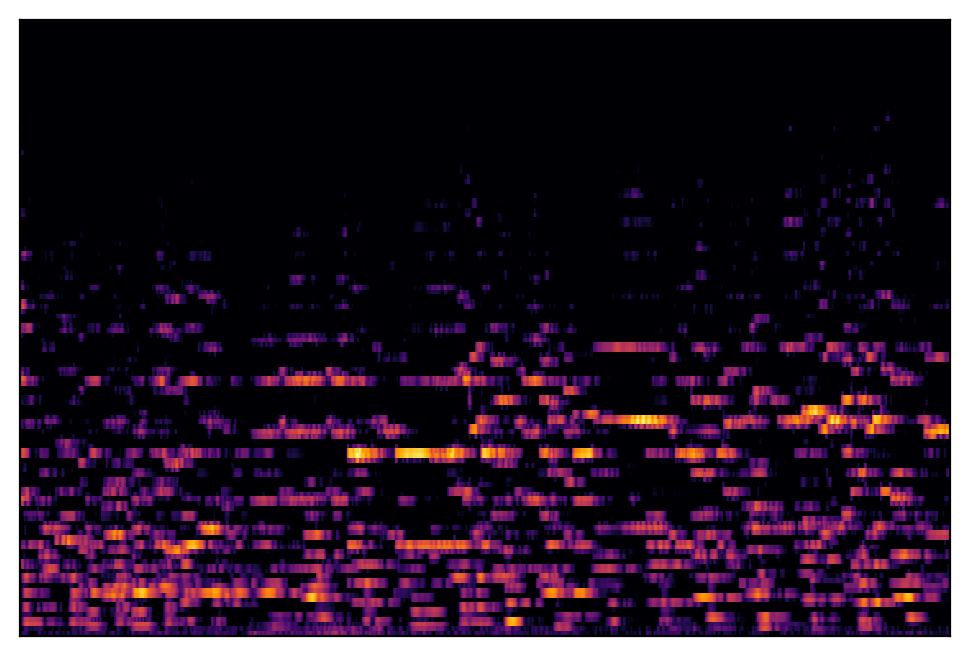

1/1 [==============================] - 0s 152ms/step
[[0.00176495 0.60319835 0.05584621 0.00465296 0.0006124  0.29458517
  0.0026158  0.0198228  0.00869849 0.00820294]]
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


Melody_Generated_Classical_1.wav - Predicted genre is  classical
Melody_Generated_Classical_2.wav


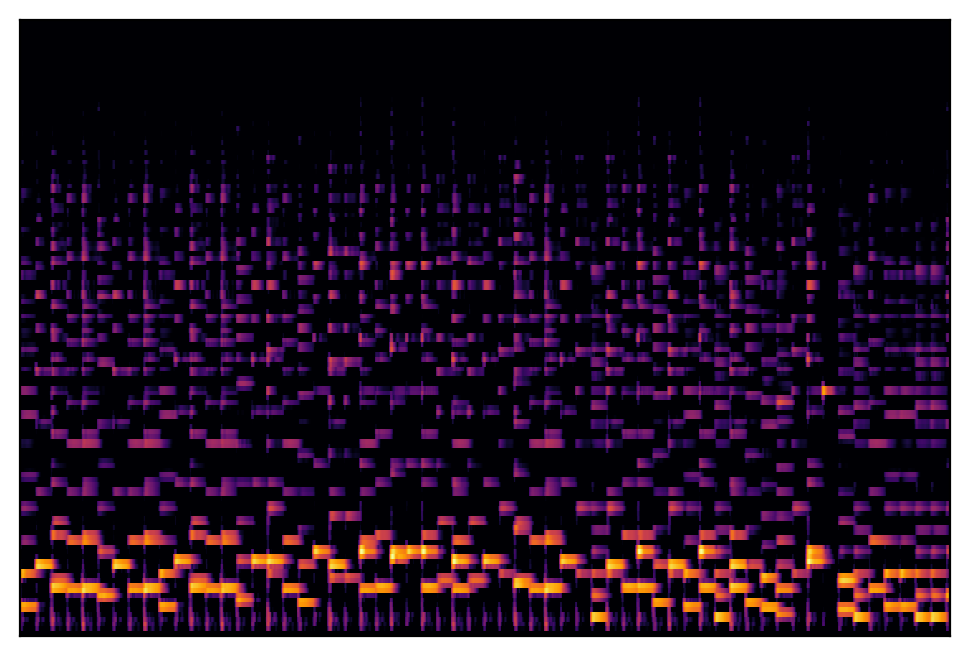

1/1 [==============================] - 0s 135ms/step
[[0.04472365 0.01403208 0.05524728 0.00476336 0.00226561 0.15960278
  0.01348399 0.15052278 0.08004099 0.47531748]]
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


Melody_Generated_Classical_2.wav - Predicted genre is  rock
Melody_Generated_Classical_3.wav


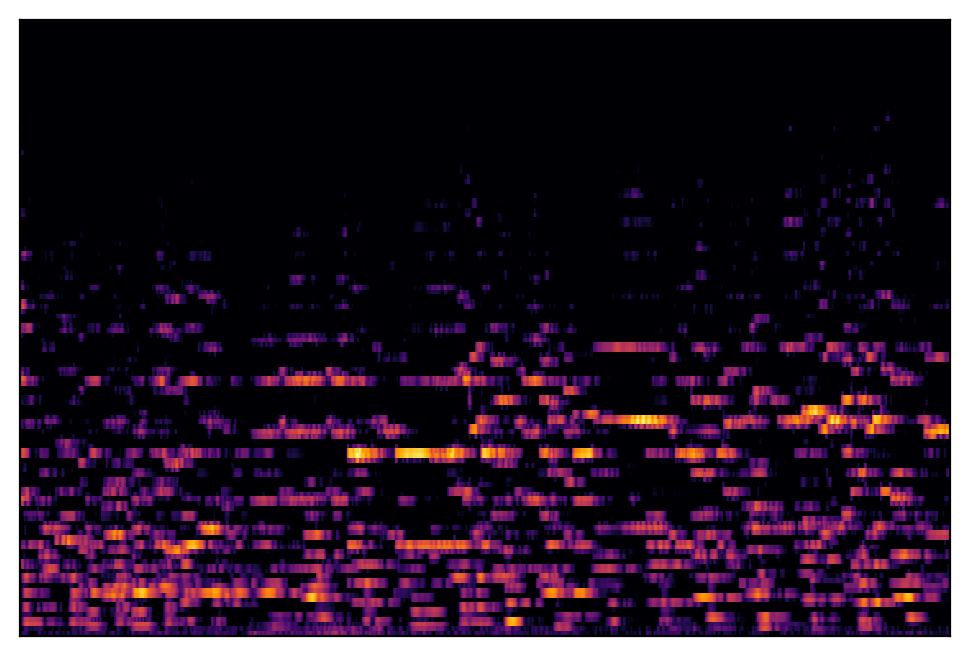

1/1 [==============================] - 0s 132ms/step
[[0.00176495 0.60319835 0.05584621 0.00465296 0.0006124  0.29458517
  0.0026158  0.0198228  0.00869849 0.00820294]]
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


Melody_Generated_Classical_3.wav - Predicted genre is  classical
Melody_Generated_Classical_4.wav


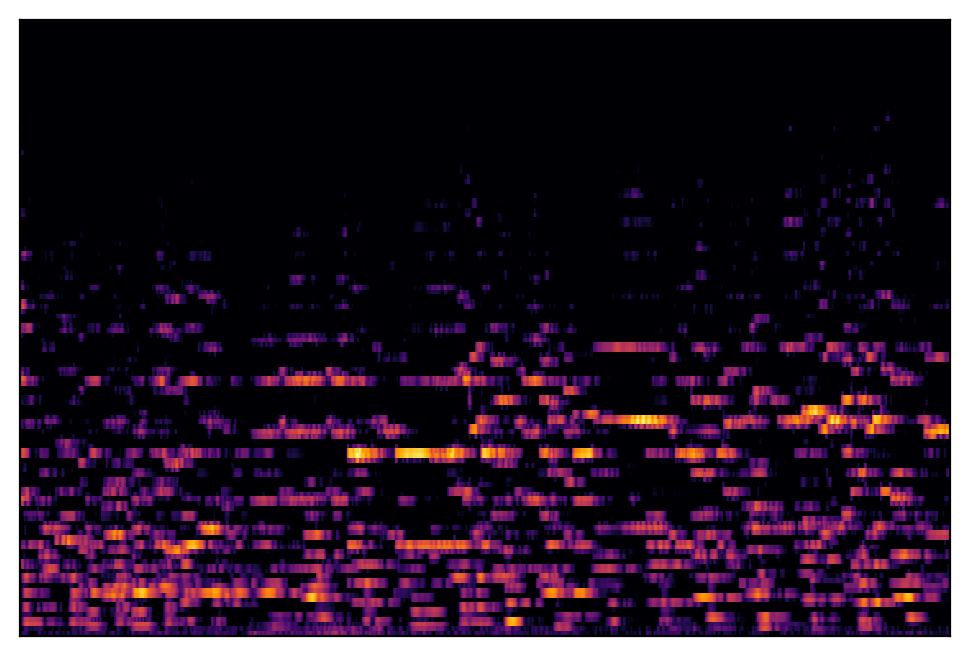

1/1 [==============================] - 0s 242ms/step
[[0.00176495 0.60319835 0.05584621 0.00465296 0.0006124  0.29458517
  0.0026158  0.0198228  0.00869849 0.00820294]]
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


Melody_Generated_Classical_4.wav - Predicted genre is  classical
Melody_Generated_Classical_5.wav


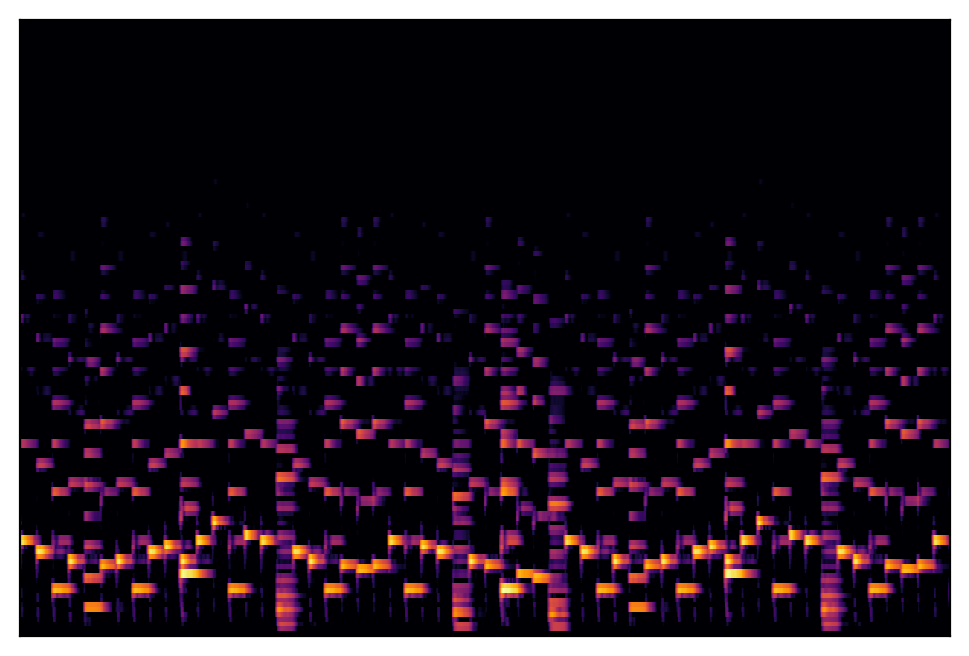

1/1 [==============================] - 0s 219ms/step
[[0.02494573 0.02302221 0.02581742 0.00599178 0.00175084 0.6172039
  0.00253157 0.09817412 0.15707755 0.04348491]]
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


Melody_Generated_Classical_5.wav - Predicted genre is  jazz


In [49]:
results = []

for i in range(1, 6):
  filepath = f"Melody_Generated_Classical_{i}.wav"
  predicted_class = predict_function(filepath)
  results.append(f'Classical Audio {i} classified as - {predicted_class}')


# Final Predictions

In [51]:
for item in results:
  print(item + "\n")

Classical Audio 1 classified as - classical

Classical Audio 2 classified as - rock

Classical Audio 3 classified as - classical

Classical Audio 4 classified as - classical

Classical Audio 5 classified as - jazz

